In [3]:
# figure14.py or any plotting script
import os
import yaml
import joblib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity

from model import CINN
from plot_utils import sample_posteriors, compute_map_estimates, build_priors_from_training


def posterior_distribution(model_checkpoint: str,
                  params_path: str,
                  processed_dir: str = "processed_data",
                  n_rows: int = 10,
                  n_samples: int = 600,
                  random_state: int = 42,
                  select_halo_ids: list = None,
                  select_snapshots: list = None):
    """
    Plot posterior vs prior vs MAP vs truth for selected test clusters.
    """

    # 1. Load data & scalers
    dfX     = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY     = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    df_meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    tar_sc  = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    X_full = dfX.values
    Y_full = dfY.values

    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape

    # 2. Re-split test set
    idx             = np.arange(N)
    idx_tmp, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    val_frac        = 0.1 / 0.9
    idx_train, idx_val = train_test_split(idx_tmp, test_size=val_frac, random_state=random_state)

    X_test    = X_full[idx_test]
    Y_test    = Y_full[idx_test]
    meta_test = df_meta.iloc[idx_test].reset_index(drop=True)

    halo_ids     = meta_test["HaloID"].values
    snapshot_ids = meta_test["Snapshot"].values

    # 3. Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with open(params_path, 'r') as f:
        params = yaml.safe_load(f)
    data_torch = torch.tensor(Y_full[idx_train], dtype=torch.float32)
    cond_torch = torch.tensor(X_full[idx_train], dtype=torch.float32)
    model = CINN(params, data_torch, cond_torch).to(device).eval()
    ckpt = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt["net"])

    # 4. Choose which samples to plot
    if select_halo_ids and select_snapshots:
        if len(select_halo_ids) != len(select_snapshots):
            raise ValueError("HaloIDs and Snapshots lists must match length")
        chosen = []
        for hid, snap in zip(select_halo_ids, select_snapshots):
            matches = meta_test[(meta_test["HaloID"] == hid) & (meta_test["Snapshot"] == snap)].index
            if len(matches) == 0:
                raise ValueError(f"No test entry for HaloID={hid}, Snapshot={snap}")
            chosen.append(matches[0])
    else:
        rng = np.random.RandomState(random_state)
        chosen = rng.choice(len(X_test), size=n_rows, replace=False).tolist()

    n_rows = len(chosen)
    X_chosen = X_test[chosen]
    Y_chosen = Y_test[chosen]
    meta_chosen = meta_test.iloc[chosen].reset_index(drop=True)

    # 5. Sample posteriors and compute MAPs
    post_phys = sample_posteriors(model, X_chosen, tar_sc, n_samples=n_samples, device=device)
    maps_phys = compute_map_estimates(post_phys)
    true_phys = tar_sc.inverse_transform(Y_chosen)

    # 6. Build priors
    priors = build_priors_from_training(tar_sc.inverse_transform(Y_test))

    # 7. Plot
    target_labels = [
        'Tiem of the Last Collision',     # T_coll (time of last collision, in Gyr)
        'Last Collision Velocity', # V_coll (velocity at last collision, in km/s)
        'Last $M_{500c}$',              # Halo mass after last collision, in 10^14 M⊙
        'Last Subcluster Mass',    # Subcluster Mass (in 10^14 M⊙)
        'Last Mass Ratio',         # Mass ratio (unitless)
        'Last Pericenter Distance' # d_peri (closest approach distance, in kpc)
    ]
    unit_labels = [
        "Gyr", "km/s", "$10^{14} M_{\\odot}$", "$10^{14} M_{\\odot}$", "unitless", "kpc"
    ]

    fig, axes = plt.subplots(n_rows, D_tar, figsize=(3 * D_tar, 1.25 * n_rows), sharex="col", squeeze=False)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    for i_row in range(n_rows):
        axes[i_row, 0].text(
            -0.15, 0.5,
            f"{meta_chosen['Snapshot'][i_row]}\n{meta_chosen['HaloID'][i_row]}",
            transform=axes[i_row, 0].transAxes,
            rotation=90, va="center", ha="center", fontsize=8
        )
        for d in range(D_tar):
            ax = axes[i_row, d]
            g_prior, pd_prior = priors[d]

            # Prior
            ax.fill_between(g_prior, pd_prior, color="lightgrey", alpha=0.6)
            ax.plot(g_prior, pd_prior, "k--", lw=1)

            # Posterior
            samp = post_phys[i_row, :, d][:, None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.6).fit(samp)
            g_post = np.linspace(samp.min(), samp.max(), 200)[:, None]
            pd_post = np.exp(kde2.score_samples(g_post)); pd_post /= pd_post.max()
            ax.plot(g_post.ravel(), pd_post, color="C0", lw=2)

            # MAP & Truth
            ax.axvline(maps_phys[i_row, d], color="gold", lw=1.5)
            ax.axvline(true_phys[i_row, d], color="red", lw=1.5)

            ax.set_xlim(g_prior.min(), g_prior.max())
            ax.set_ylim(0, None)

            if i_row == n_rows - 1:
                ax.set_xlabel(f"{target_labels[d]} ({unit_labels[d]})", fontsize=10)
            else:
                ax.set_xticks([])

            if i_row == 0:
                ax.set_title(target_labels[d], fontsize=10)

            ax.set_yticks([])

    plt.tight_layout()
    plt.savefig("1.posterior_distribution.png", dpi=300)
    #plt.savefig("1.posterior_distribution.pdf", dpi=300)
    plt.show()


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


num samples out of bounds: 0
number of parameters: 727736
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


/tmp/ipykernel_41616/4168906505.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_checkpoint, map_location=device)


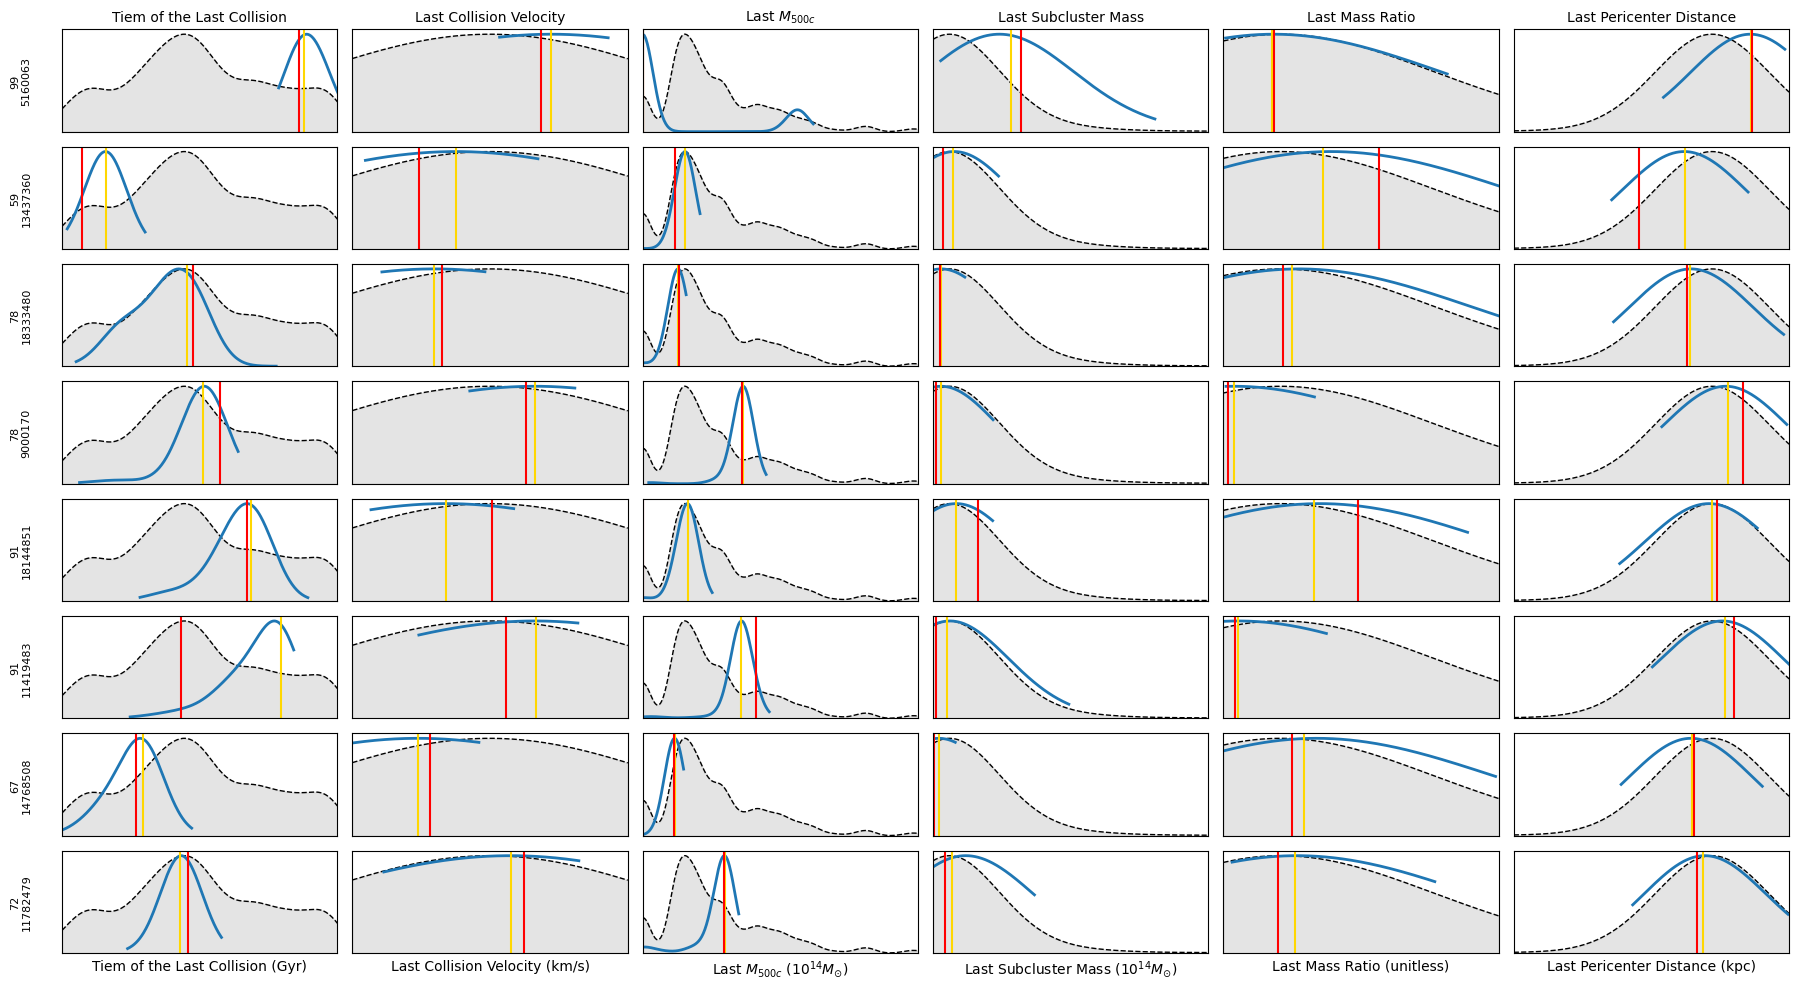

In [4]:
posterior_distribution(
    model_checkpoint="runs/20250530_211943_no_scaling/model_last.pt",
    params_path="params.yaml",
    processed_dir="processed_data",
    n_rows=8,
    n_samples=1000
)